In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
import pickle
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, memory_summarizer_node, graph_and_exploitation_inference_node, exposure_manager_node, event_summarizer_node, firewall_node, save_iteration_node, node_utils
from configuration.state import HoneypotStateReact
from configuration import memory
from prompts import firewall_executor_prompt
nest_asyncio.apply()
import benchmark.benchmark as b


def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=node_utils.POLITO_CLUSTER_KEY, base_url=node_utils.POLITO_URL)
        response = client.chat.completions.create(
            model=node_utils.MISTRAL_STRING,
            messages=[{"role":"system", "content":"ciao"}],
            )
        print(response.choices[0].message.content)
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:
# Load environment variables
load_dotenv()
os.environ["POLITO_CLUSTER_KEY"] = os.getenv("POLITO_CLUSTER_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 200 OK"


 Hello! How can I assist you today?
API key is valid: True


In [3]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "persistence_node"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "persistence_node"

In [4]:
def build_graph():
    graph = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    #graph.add_node("memory_summarizer", memory_summarizer_node.memory_summarizer)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    graph.add_node("graph_and_exploitation_inference", graph_and_exploitation_inference_node.graph_and_exploitation_inference)
    graph.add_node("exposure_manager", exposure_manager_node.exposure_manager)
    graph.add_node("firewall_manager", firewall_node.firewall_executor)
    graph.add_node("persistence_node", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer") 
    graph.add_edge("event_summarizer", "graph_and_exploitation_inference")
    graph.add_edge("graph_and_exploitation_inference", "exposure_manager")
    graph.add_edge("exposure_manager", "firewall_manager")
    graph.add_conditional_edges("firewall_manager", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "persistence_node")
    graph.add_edge("persistence_node", END)

        
    return graph.compile()

def build_graph_test():
    graph = StateGraph(HoneypotStateReact)
    
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer") 
    graph.add_edge("event_summarizer", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:43929/devtools/browser/0582ae2d-a770-4f4a-b026-01e0f3c36352
INFO:pyppeteer.launcher:terminate chrome process...


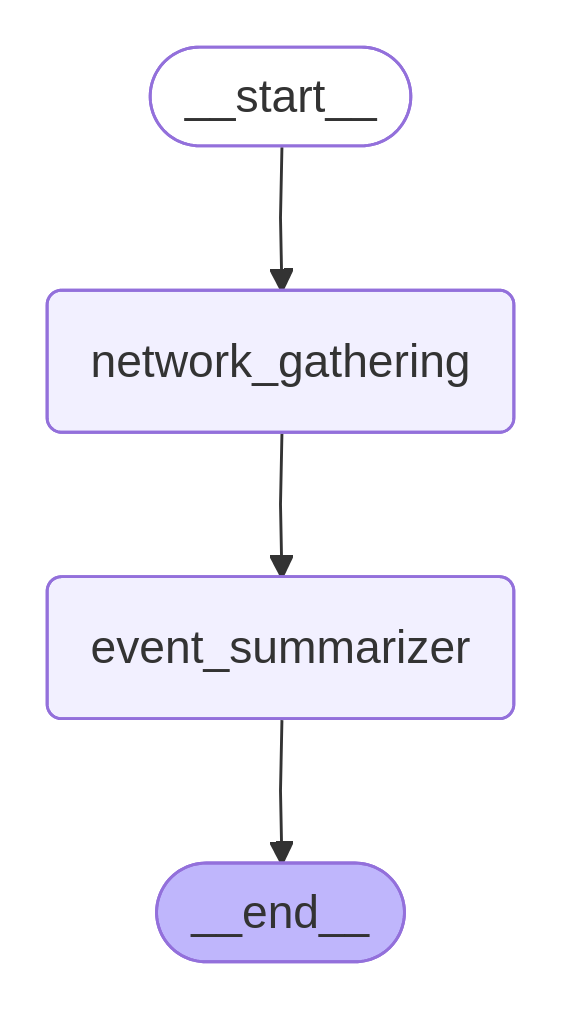

In [5]:
#graph = build_graph()
graph = build_graph_test()
display_graph(graph)

## Single Iteration

In [6]:
episodic_memory = memory.EpisodicMemory()

In [7]:
responses = []
for i in range(1):
    initial_state = HoneypotStateReact(
        messages=[]
    )
    response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"eve", "time_window":2, "epoch_num":i+1, "model_config":"mistral"}})
    responses.append(response)

INFO:nodes.network_gathering_node:Network gathering Node


INFO:nodes.event_summarizer_node:Summarizer Agent
INFO:nodes.event_summarizer_node:Using Mistral model
INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:openai._base_client:Retrying request to /chat/completions in 0.403025 seconds
INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:openai._base_client:Retrying request to /chat/completions in 0.945763 seconds
INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:openai._base_client:Retrying request to /chat/completions in 0.488528 seconds
INFO:httpx:HTTP Request: POST https://kubernetes.polito.it/vllm/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:openai._base_client:Retrying request t

InstructorRetryException: <failed_attempts>

<generation number="1">
<exception>
    Error code: 500 - {'detail': 'Internal server error'}
</exception>
<completion>
    None
</completion>
</generation>

<generation number="2">
<exception>
    Error code: 500 - {'detail': 'Internal server error'}
</exception>
<completion>
    None
</completion>
</generation>

<generation number="3">
<exception>
    Error code: 500 - {'detail': 'Internal server error'}
</exception>
<completion>
    None
</completion>
</generation>

</failed_attempts>

<last_exception>
    Error code: 500 - {'detail': 'Internal server error'}
</last_exception>

In [10]:
for response in responses:
    for m in response['messages']:
        m.pretty_print()

================================ Human Message =================================

{'alerts': [{'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.6', 'dest_port': 443, 'flow_id': 1634000565820442, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 37705, 'timestamp': '2025-09-19T19:08:29.970269+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.55', 'dest_port': 443, 'flow_id': 1937432732673276, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 37703, 'timestamp': '2025-09-19T19:08:30.123413+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.86', 'dest_port': 443, 'flow_id': 1948472029045211, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 37703, 'timestamp': '2025-09-19T19:08:30.125983+0200'}

## Benchmark

In [3]:
episodic_memory = memory.EpisodicMemory()
dir_name = "2_exploitable_2_decoys"

config_dict = {
            "max_epochs": 15,
            "attack_duration": 240,
            "monitor_accumulation_wait": 5,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": dir_name
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":2, 
            "prompt":"eve",
            "epoch_num": epoch_num,
            "model_config": "small:5"
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "wb") as f:
    pickle.dump(responses, f)

NameError: name 'memory' is not defined

In [7]:
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

Epoch: 1
================================ Human Message =================================

{'alerts': [{'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.11', 'dest_port': 443, 'flow_id': 1349659513772539, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 38350, 'timestamp': '2025-09-18T15:43:08.183170+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.59', 'dest_port': 443, 'flow_id': 1376635574415822, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 38350, 'timestamp': '2025-09-18T15:43:08.386058+0200'}, {'category': 'Attempted Information Leak', 'dest_ip': '172.20.0.93', 'dest_port': 443, 'flow_id': 1387478731152564, 'payload': None, 'proto': 'TCP', 'severity': 2, 'signature': 'POSSBL PORT SCAN (NMAP -sS)', 'src_ip': '192.168.100.2', 'src_port': 38350, 'timestamp': '2025-09-18T15:43:08.388

In [8]:
dir_name = 'all_exploitable'
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "rb") as f:
    saved_responses = pickle.load(f)

for i, res in enumerate(saved_responses):
    print(f"Epoch {i+1}")
    for m in res["messages"]:
        m.pretty_print()

Epoch 1
================================ Human Message =================================

{'alerts': [{'category': 'Misc activity', 'dest_ip': '192.168.100.254', 'dest_port': None, 'flow_id': 1147757474990773, 'payload': 'dl.h....1....................... !"#$%&\'()*+,-./01234567', 'proto': 'ICMP', 'severity': 3, 'signature': 'GPL ICMP PING *NIX', 'src_ip': '192.168.100.2', 'src_port': None, 'timestamp': '2025-09-15T21:43:32.529377+0200'}, {'category': 'Misc activity', 'dest_ip': '192.168.100.254', 'dest_port': None, 'flow_id': 1147757474990773, 'payload': 'el.h....]....................... !"#$%&\'()*+,-./01234567', 'proto': 'ICMP', 'severity': 3, 'signature': 'GPL ICMP PING *NIX', 'src_ip': '192.168.100.2', 'src_port': None, 'timestamp': '2025-09-15T21:43:33.578438+0200'}, {'category': 'Misc activity', 'dest_ip': '192.168.100.254', 'dest_port': None, 'flow_id': 1147757474990773, 'payload': 'fl.h...."-...................... !"#$%&\'()*+,-./01234567', 'proto': 'ICMP', 'severity': 3, 'sig